In [1]:
%cd ..

/Users/christianbergen/Documents/prog/aaa21


In [2]:
import clustering
import utils


In [3]:
chicago_df = utils.read_parquet('chicago_taxi_trips_15percent_sample.parquet',
                                columns=['Trip ID','Pickup Community Area',
                                         'Trip Start Hour','Trip Kilometers'])
chicago_df.head()

,Trip ID,Pickup Community Area,Trip Start Hour,Trip Kilometers
0,3da435c5014f824c60972a99a3897b9de734d465,33.0,17,3.70
1,87986102b53baf98f56396c200342d7579744649,32.0,21,1.77
2,f6fabf24c194197e67852a193d9318a84ed30a0a,28.0,17,12.23
3,0536c5f7c1bf1fb885b5ba43a124ba0239e4cae6,32.0,12,0.16
4,0d78eba1d870afcdafce5056feaf572acacac601,8.0,9,3.06


In [4]:
chicago_df.drop(columns=['Trip ID','Pickup Community Area'], axis=1,inplace=True)


In [5]:
chicago_df['Trip Kilometers'] = chicago_df['Trip Kilometers'].astype('float')
chicago_df_q = chicago_df[(chicago_df['Trip Kilometers'] < chicago_df['Trip Kilometers'].quantile(0.95))]

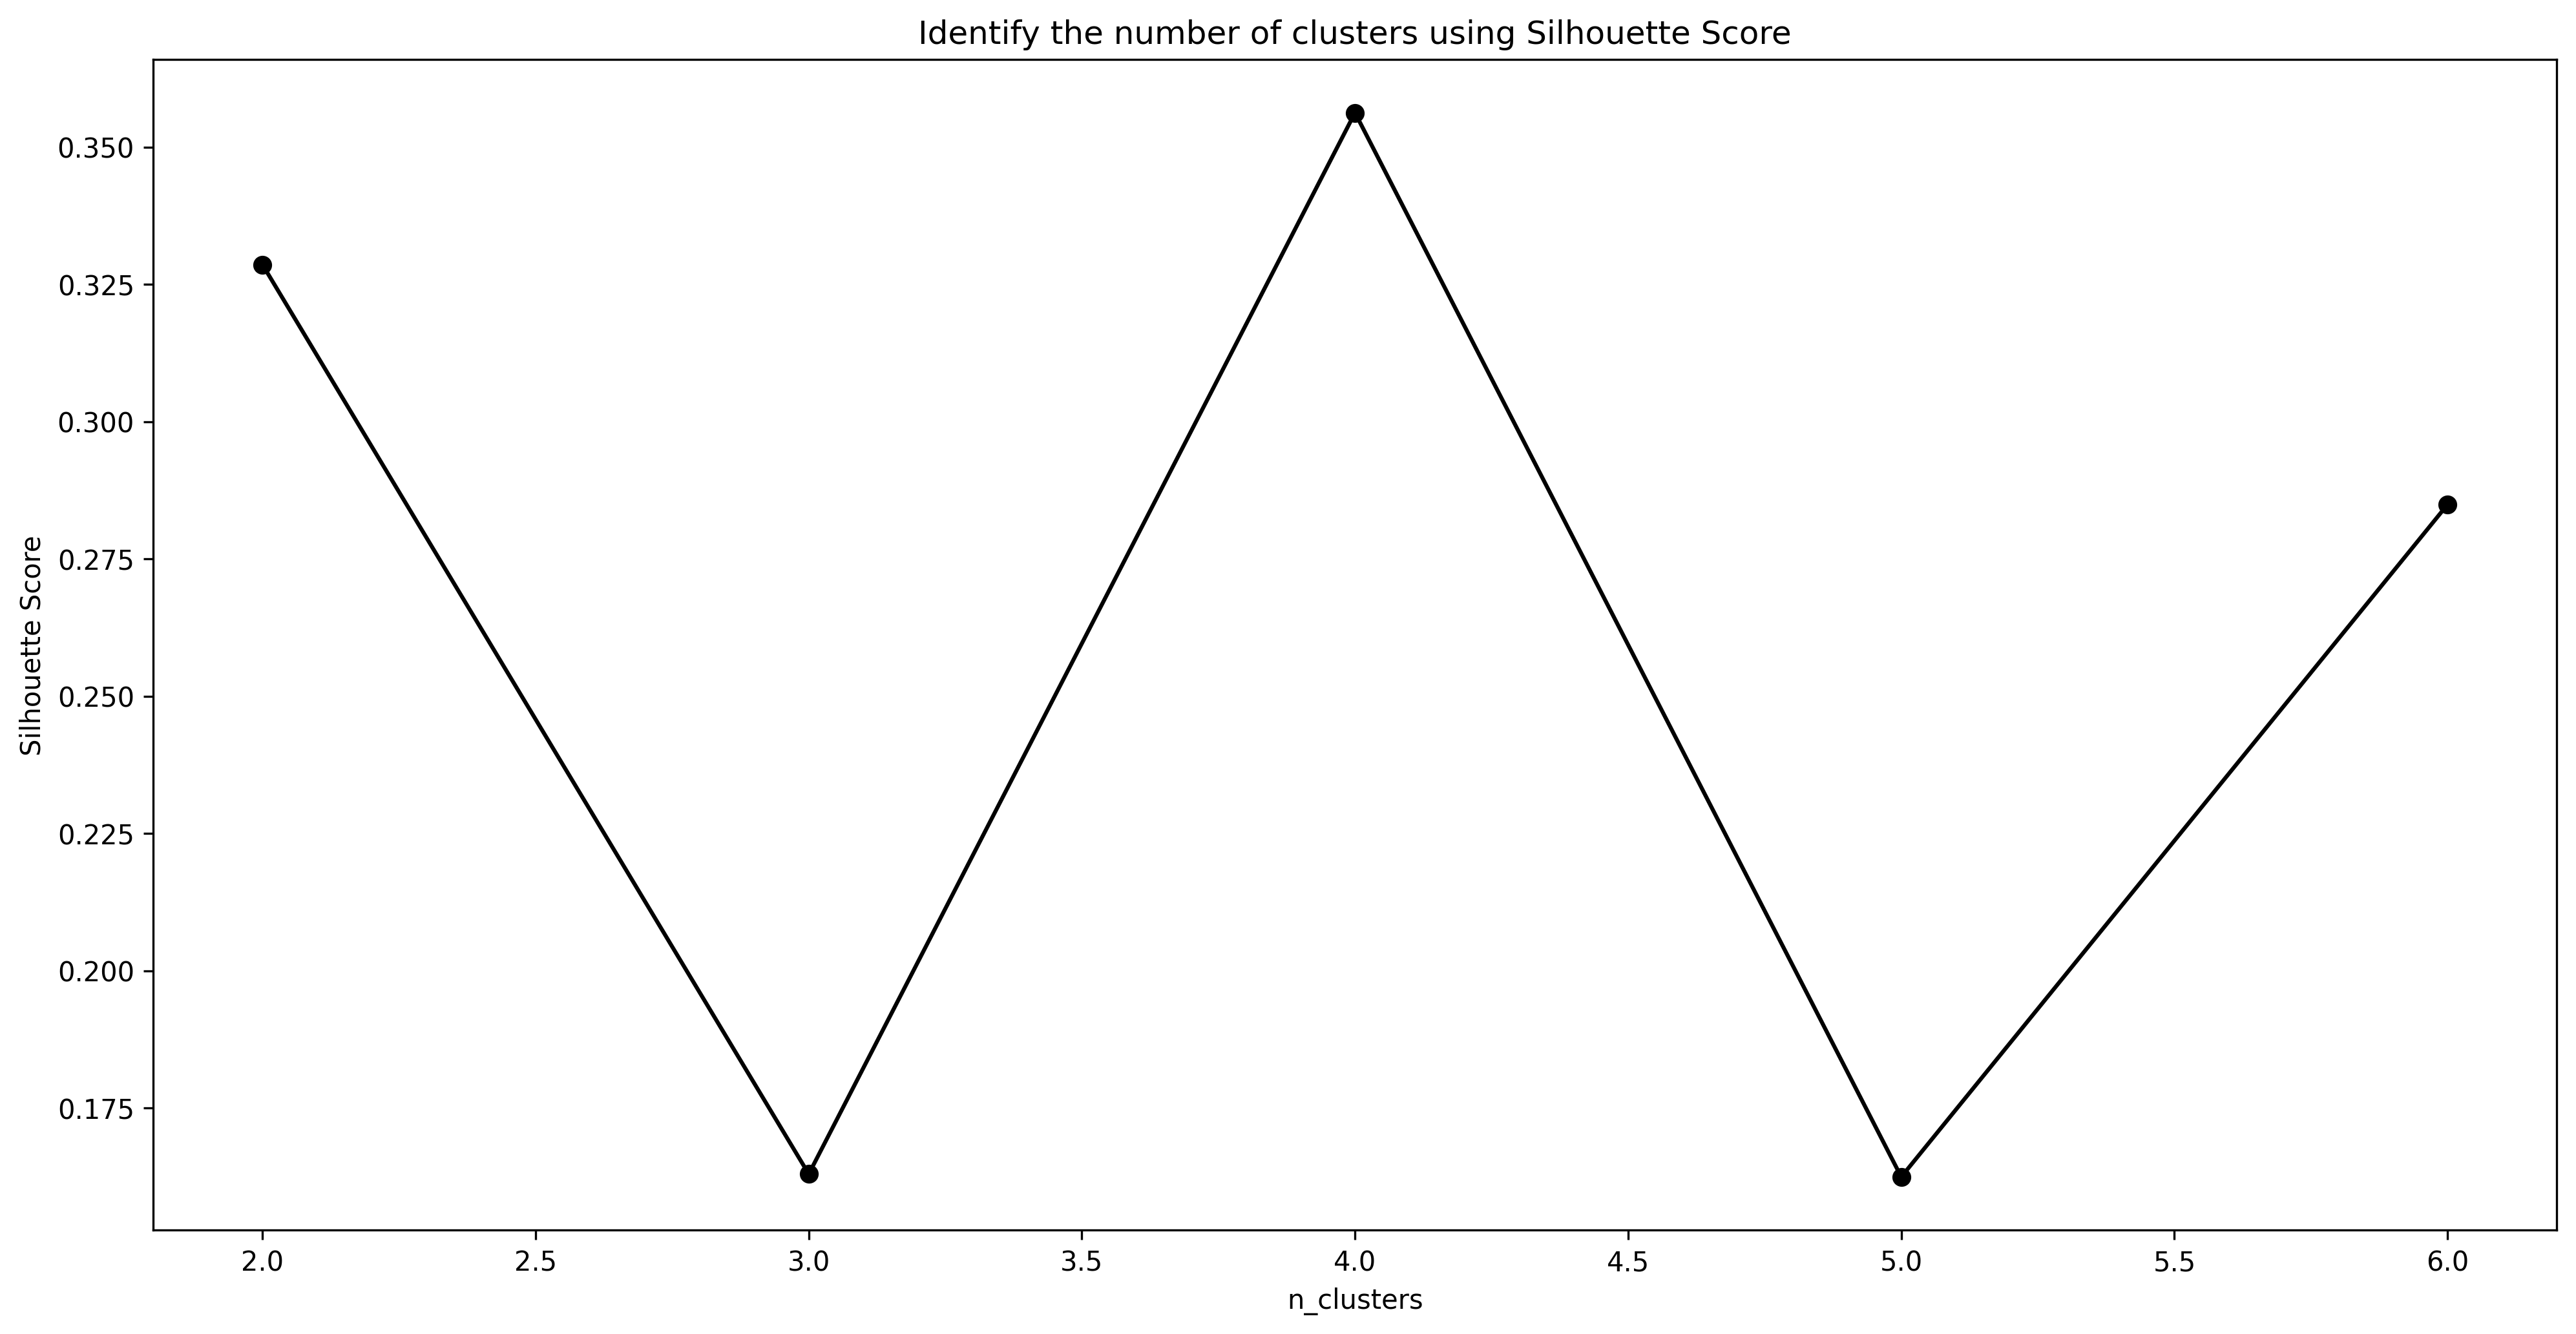

In [6]:
clustering.get_silhouette_score(chicago_df_q , "Trip Start Hour","Trip Kilometers" , 5)

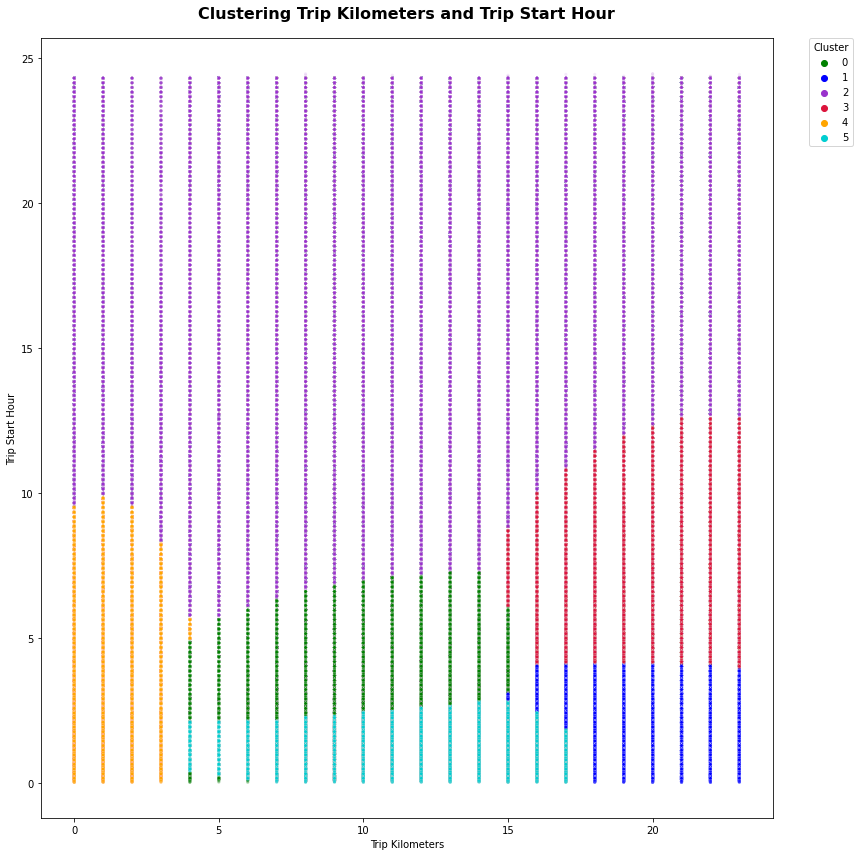

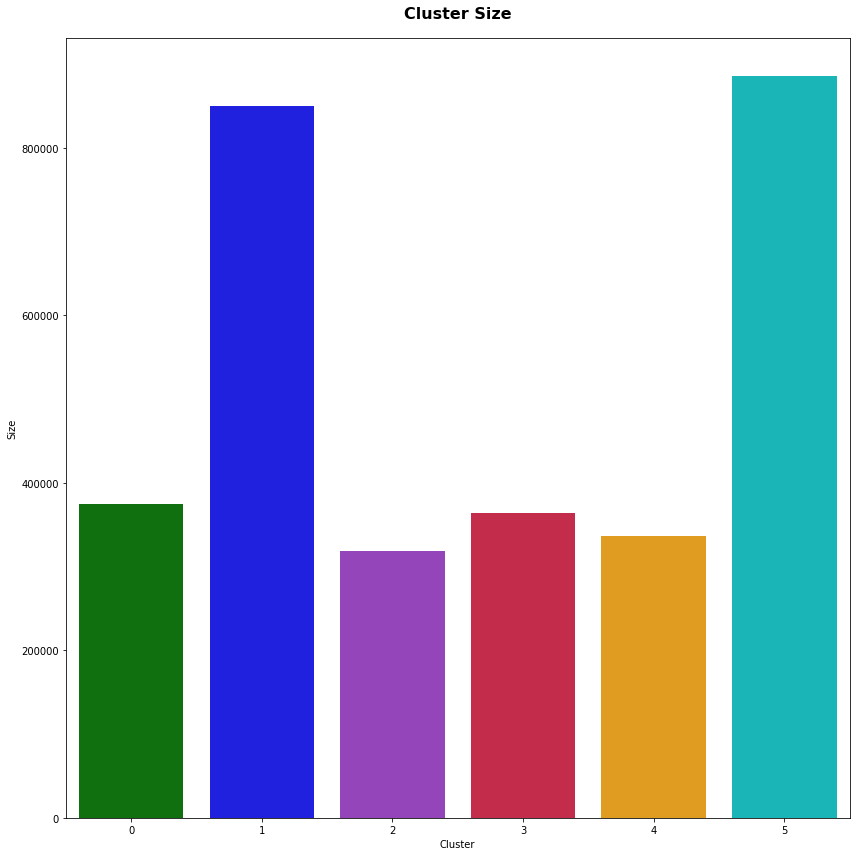

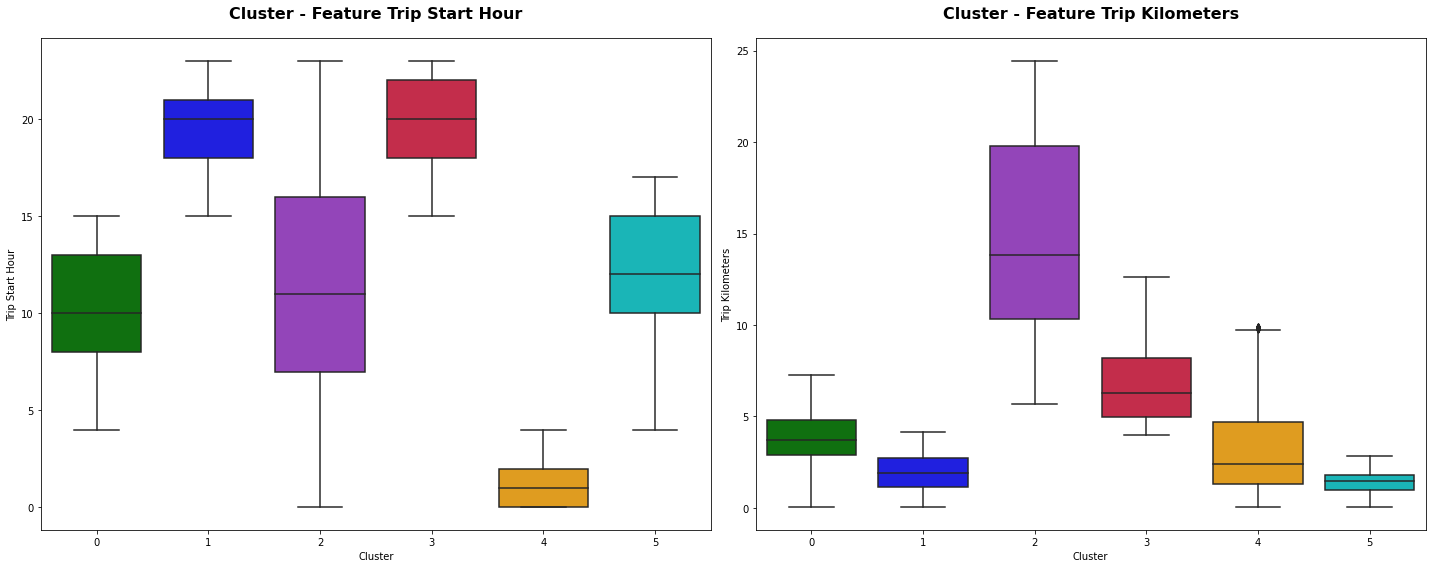

In [7]:
clustering.get_clusters_gmm(chicago_df_q,
                 column_1="Trip Start Hour",
                 column_2="Trip Kilometers",
                 title = "Clustering Trip Kilometers and Trip Start Hour",
                 xlabel="Trip Kilometers",
                 ylabel="Trip Start Hour",
                 n_cluster=6,
                 plot_sizes=True,
                 plot_boxes=True,
                 )

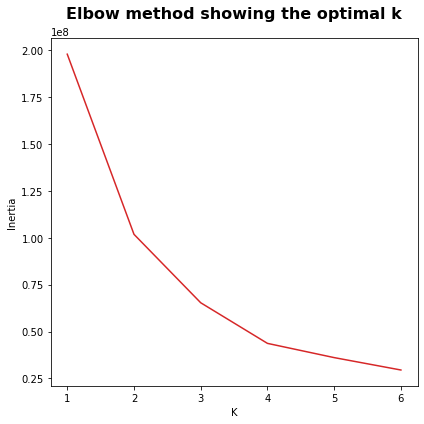

In [6]:
clustering.get_ellbow(chicago_df_q[["Trip Kilometers", "Trip Start Hour"]], 7)



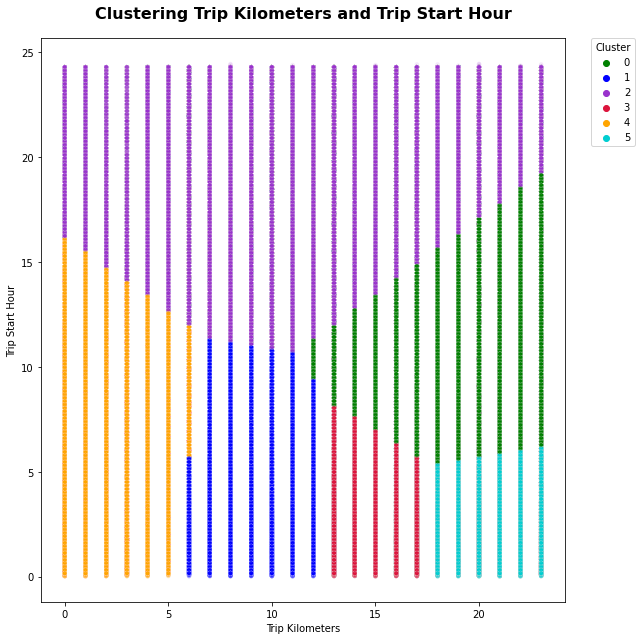

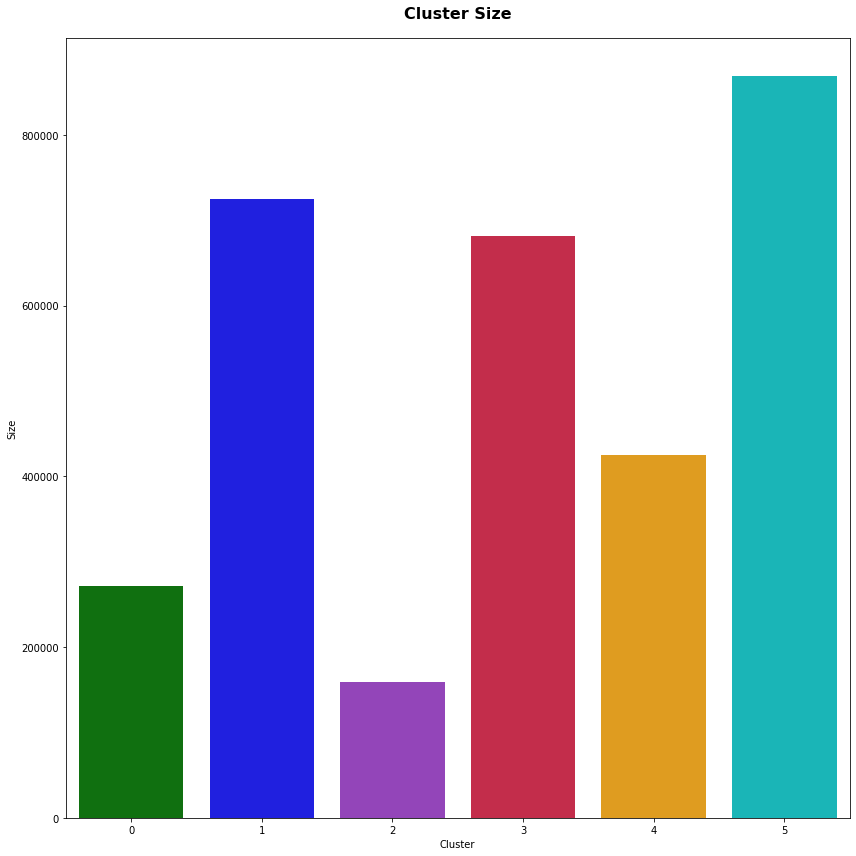

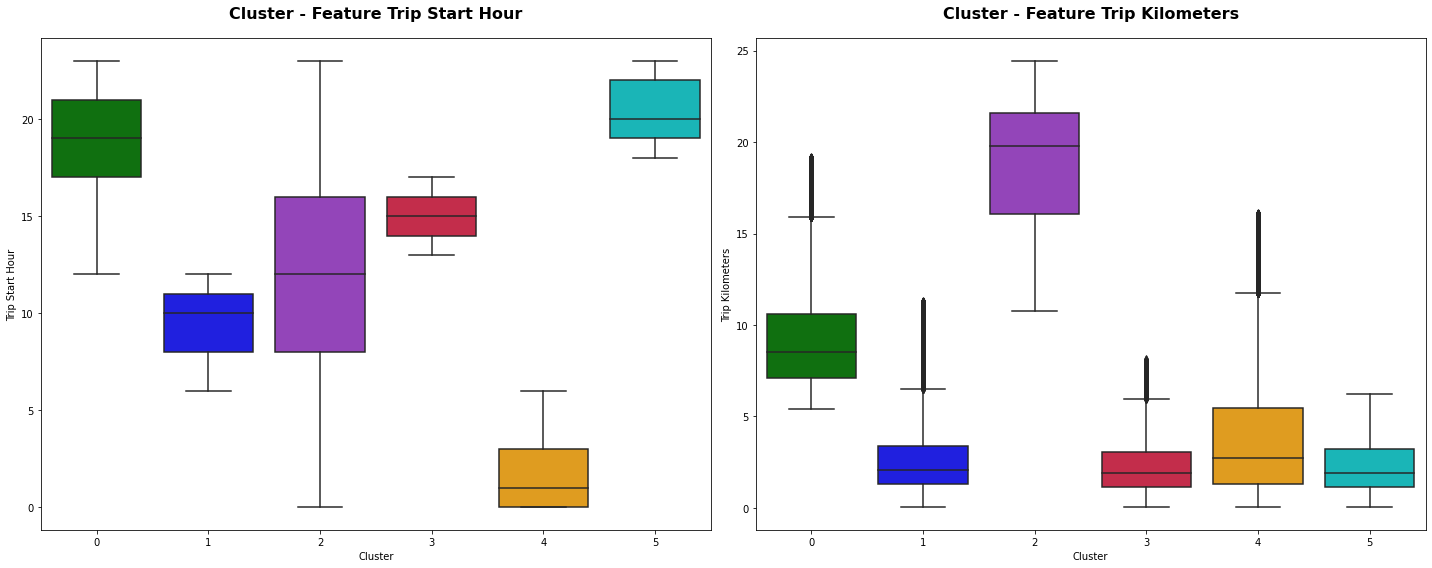

In [6]:
clustering.get_clusters_kmeans(chicago_df_q,
                 column_1="Trip Start Hour",
                 column_2="Trip Kilometers",
                 numerical_columns = ["Trip Kilometers"],
                 title = "Clustering Trip Kilometers and Trip Start Hour",
                 xlabel="Trip Kilometers",
                 ylabel="Trip Start Hour",
                 n_cluster=6,
                 plot_sizes=True,
                 plot_boxes=True,
                )